<h1> GAN - CNN</h1>
- Nutze CNN statt ANN

Dieses Notebook basiert auf "1_intoduce-GAN-ANN". Diesmal wird ein CNN Netz angewendet, um die Qualität zu steigern.

<i>Abb1</i>: Übersicht GAN.

<img src="./data/img/2_gan.PNG" height=500 width=700>

Weitere Inhalte zu GAN:

> GAN Applications: Everything You Need to Know <br>
> https://neptune.ai/blog/generative-adversarial-networks-gan-applications [Letzter Zugriff: 23.07.2024]

Als Erstes werden wir wieder nur eine Klasse nutzen und versuchen mit einem Generator basierend auf CNN ein Bild zu erzeugen.

Als Einstieg soll der Generator ein 100*100 Pixelbild eines Apfels herstellen. 

In [106]:
# Imports.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os

Hier werden wir die Funktionsweise des Faltungsnetzes umkehren. Zu Beginn geben wir die Dimension des Bildes an, das dann Hochskaliert wird.

>tf.keras.layers.Conv2DTranspose:<br>
>https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose [Letzter Zugriff: 23.07.2024]

<h2>Dataset</h2>

Wir wollen mit dem Generator syntetische Apfelbilder erzeugen, für das Training nutzen wir ein Dataset das verschiedene Früchte enthählt und wählen eine Sorte aus.

> Fruits-360 dataset: A dataset with 90380 images of 131 fruits, vegetables and nuts. <br>
> https://www.kaggle.com/datasets/moltean/fruits [Letzter Zugriff: 23.07.2024]

In [99]:
url="data/datasets/archive/fruits-360_dataset/fruits-360/Training/Apple_Pink_Lady/"
img = PIL.Image.open(url+"0_100.jpg", mode='r')

In [100]:
np.asarray(img).shape

(100, 100, 3)

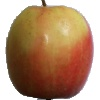

In [101]:
img

In [102]:
appleimage_names = os.listdir(url)
appleimage_names[0]

'0_100.jpg'

In [103]:
# Erstelle Numpy Dataset
apple_dataset = [np.asarray(PIL.Image.open(url+name, mode='r'))  for name in appleimage_names]
len(apple_dataset) == len(appleimage_names)

True

In [7]:
len(appleimage_names)

456

<h2>Aufbau Netz</h2>

In [8]:
image_dim = 100*100
noise_dim = 125

In [15]:
# Generator soll Bild erzeugen.
def create_generator(img_dim:int=125):
    model = tf.keras.Sequential()
    # ---- # 
    model.add(tf.keras.layers.Dense(units=25*25*256, input_shape=(img_dim, ), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape(( 25, 25, 256)))  
    # ---- # 
    # Transpose # 1
    model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(4,4),  padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU()) 
     # Transpose # 1
    model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(4,4),  padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU()) 
    # Transpose # 2
    model.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), padding='same', use_bias=False))  # Durch Strides, Filters und Padding wird Output skaliert.
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  
    # Transpose # 3
    model.add(tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(2,2), strides=(1,1), padding='same', use_bias=False))  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())   
    # Transpose # 4
    model.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=(1,1), strides=(1,1), padding='same', use_bias=False))  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())   # leaky

    model.add(tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    # Anders als bei einem ANN muss der Output nicht extra 

    return model
    

Beim Konstruieren kann so z. B. der Output und die Form eingesehen und weitere Informationen ausgegeben werden.

Der Aufbau hier ist wieder recht simpel, wenn es darum geht nur eine Klasse eines Bildes zu erzeugen.

In [510]:
noise = np.random.normal(0, 1, (1, 125))  
generator = create_generator(noise_dim)
img = generator(noise)
img.shape

TensorShape([1, 100, 100, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013359457..0.017885402].


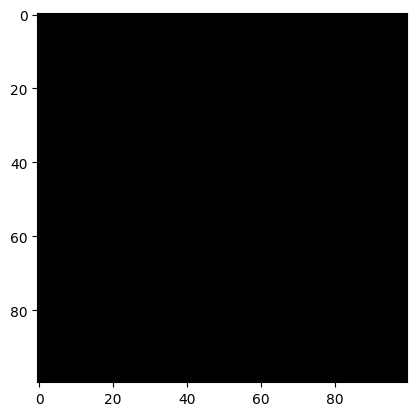

In [447]:
plt.imshow(img[0])

Jetzt kommt der Discriminator.

In [16]:
def create_discriminator():
    model = tf.keras.Sequential()
    # --- # 
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(4,4), strides=(1,1), input_shape=(100,100,3), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), strides=(1,1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(2,2), strides=(1,1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    return model
    

In [538]:
discriminator = create_discriminator()
discriminator.build(input_shape=(1,104,104,3))
discriminator.summary()

Model: "sequential_112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 100, 100, 128)     6272      
                                                                 
 leaky_re_lu_377 (LeakyReLU)  (None, 100, 100, 128)    0         
                                                                 
 dropout_69 (Dropout)        (None, 100, 100, 128)     0         
                                                                 
 conv2d_75 (Conv2D)          (None, 50, 50, 64)        32832     
                                                                 
 leaky_re_lu_378 (LeakyReLU)  (None, 50, 50, 64)       0         
                                                                 
 dropout_70 (Dropout)        (None, 50, 50, 64)        0         
                                                                 
 conv2d_76 (Conv2D)          (None, 50, 50, 16)     

<u>Hinweis:</u><br>
Es gibt verschiedene Arten von GANs wie z. B. Wasserstein-GAN das bessere Ergebnis liefert. Hier geht es darum, sich allgemein mit GAN zu beschäftigen. In anderen Notebooks werden weitere Varianten und Details besprochen sowie deren Unterschiede und Probleme.

<h2>Training 1</h2>

Danach erstellen wir das GAN-Netzwerk und trainieren es. Es gibt einige Möglichkeiten dies zu tun. Die unteren Beispiele Zeigen einige Routinen die nach Bedarf weiter angepasst werden können.

In [218]:
# Erstelle Modelle. 
generator     = create_generator()
discriminator = create_discriminator()

In [219]:
# Kompiliere Modelle.
generator.compile(optimizer='adam', loss='binary_crossentropy')

discriminator.compile(
    optimizer = 'adam',
    loss      = 'binary_crossentropy'
)

Während des Trainings haben wir die Option generierte Bilder zu speichern. Hier speichern wir das Bild als Array, um es später zu Ploten.

In [223]:
# Trainingsschleife # 
# - Beide Modelle werden trainiert
def train(real_images, generator, discriminator, batch_size: int = 16, epochs: int = 400):
    
    half_batch = int(batch_size / 2)
    # Sammle Loss für Plot.
    d_losses = []
    g_losses = []
    gen_img_array = []

    for epoch in range(epochs):
        idx        = np.random.randint(0, real_images.shape[0], half_batch)  # Ziehe Samples
        real_imgs  = real_images[idx]  # Hole Samples
        noise      = np.random.normal(0, 1, (half_batch, 125))  # Erstelle Startbild- Rauschen.
        
        # Discriminator # 
        with tf.GradientTape() as d_tape:
            
            generated_images = generator(noise, training=True)
            real_output      = discriminator(real_imgs, training=True)
            fake_output      = discriminator(generated_images, training=True)

            # Berechne Loss #
            # discriminator.train_on_batch(<>)
            loss_real = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
            loss_fake = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
            d_loss = tf.reduce_mean(loss_real) + tf.reduce_mean(loss_fake)
            
        # Wende die Gradienten an.
        d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
        discriminator.optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

        # Generator # 
        noise = np.random.normal(0, 1, (half_batch, 125))
        with tf.GradientTape() as g_tape:
            
            generated_images = generator(noise, training=True)
            fake_output = discriminator(generated_images, training=True)

            # Berechne Loss # 
            g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
            g_loss = tf.reduce_mean(g_loss)

        # Wende Gradienten an.
        g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
        generator.optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

        print(f"Epoch: {epoch + 1}/{epochs} D_loss: {d_loss.numpy()} G_loss: {g_loss.numpy()}")
        d_losses.append(d_loss)  # Hänge Loss an für den Plot. 
        g_losses.append(g_loss)
        if epoch%200==0:
            gen_img_array.append(generator.predict(noise))

    return gen_img_array, d_losses, g_losses


In [91]:
# Skaliere. 
numpy_images = (np.asarray(apple_dataset) - 127.5) / 127.5

In [224]:
generated_img, d_losses, g_losses = train(numpy_images, generator, discriminator, 8, 801)

Epoch: 1/801 D_loss: 1.4153599739074707 G_loss: 0.6461603045463562
1/1 [==============================] - 0s 166ms/step
Epoch: 2/801 D_loss: 1.0624154806137085 G_loss: 0.7618343234062195
Epoch: 3/801 D_loss: 0.8017574548721313 G_loss: 1.0101494789123535
Epoch: 4/801 D_loss: 0.569743812084198 G_loss: 1.5921497344970703
Epoch: 5/801 D_loss: 0.35796403884887695 G_loss: 2.897578716278076
Epoch: 6/801 D_loss: 0.1135021224617958 G_loss: 4.936011791229248
Epoch: 7/801 D_loss: 0.030204903334379196 G_loss: 7.125429630279541
Epoch: 8/801 D_loss: 0.05367529019713402 G_loss: 8.549622535705566
Epoch: 9/801 D_loss: 0.0038080550730228424 G_loss: 9.25843620300293
Epoch: 10/801 D_loss: 0.0031665076967328787 G_loss: 9.003335952758789
Epoch: 11/801 D_loss: 0.004733597859740257 G_loss: 7.877109527587891
Epoch: 12/801 D_loss: 0.036103274673223495 G_loss: 8.293058395385742
Epoch: 13/801 D_loss: 0.046606600284576416 G_loss: 8.430103302001953
Epoch: 14/801 D_loss: 0.0099289296194911 G_loss: 10.364490509033203

Mit weiteren Optimierungen können die Netze besseren Output liefern.

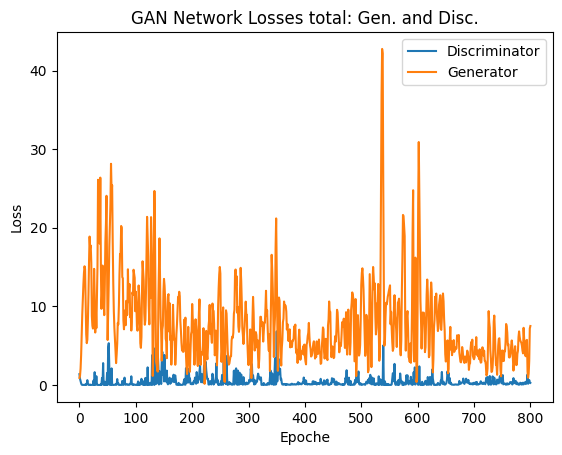

In [95]:
#plt.figure(figsize=(16, 8))
plt.title("GAN Network Losses total: Gen. and Disc.")
plt.xlabel("Epoche")
plt.ylabel("Loss")

plt.plot(range(len(d_losses)), d_losses, label="Discriminator")
plt.plot(range(len(g_losses)), g_losses, label="Generator")
plt.legend()

Um den Fortschritt sichtbar zu machen werden die Bilder die gesammelt wurden in einem Plot gezeigt. 

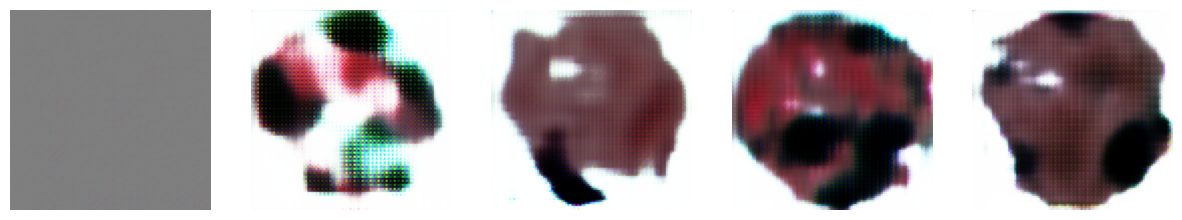

In [225]:
fig, axs = plt.subplots(1,len(generated_img), figsize=(15, 6))
axs = axs.ravel()

for i in range(len(generated_img)):
    img = generated_img[i][0]
    img  = (img * 127.5 + 127.5).astype(np.uint8)
    axs[i].set_axis_off()
    axs[i].imshow(img)

1/1 [==============================] - 0s 30ms/step


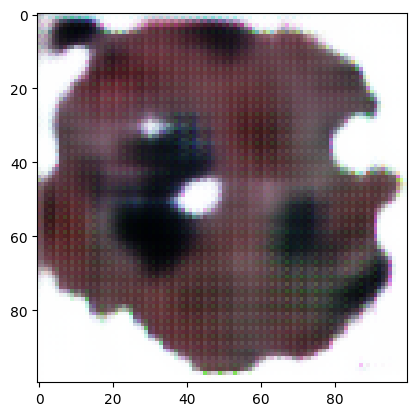

In [232]:
# Generiere ein Bild.
noise = np.random.normal(0, 1, (1, 125))  
fake_img = generator.predict(noise)
generated_image = (fake_img * 127.5 + 127.5).astype(np.uint8)
plt.imshow(generated_image[0])

<h2>Training 2 - Nutze TensorFlow Dataset</h2>

Hier wollen wir das Training etwas anders gestalten. 

Siehe:
> Writing a training loop from scratch <br>
> https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch [Letzter Zugriff: 24.07.2024]

Erstelle ein TF Dataset.

In [221]:
url="data/datasets/archive/fruits-360_dataset/fruits-360/Training/Apple_Red_Delicious/"
appleimage_names = os.listdir(url)

apple_dataset = [np.asarray(PIL.Image.open(url+name, mode='r'))  for name in appleimage_names]
len(apple_dataset) == len(appleimage_names)

True

In [222]:
apple_dataset = (np.asarray(apple_dataset) - 127.5) / 127.5

In [168]:
# Erstelle TF Dataset.
batch_size = 16

apple_dataset_tf = tf.data.Dataset.from_tensor_slices(apple_dataset).shuffle(buffer_size=1024).batch(batch_size//2)
apple_dataset_tf

<BatchDataset element_spec=TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float64, name=None)>

In [169]:
# Erstelle Modelle. 
generator     = create_generator()
discriminator = create_discriminator()

# Kompiliere Modelle.
generator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.compile(
    optimizer = 'adam',
    loss      = 'binary_crossentropy'
)

In [172]:
# Trainingsschleife # 
# - Beide Modelle werden trainiert
def train(real_images, generator, discriminator, batch_size=16, epochs=4):
    
    half_batch = int(batch_size / 2)
    
    #
    # Oder erstelle / transformiere Dataset hier. # 
    #
    
    for epoch in range(epochs):
        print(f"Starte Epoche {epoch+1}")
        for step, real_imgs in enumerate(real_images):
            
            noise = np.random.normal(0, 1, (half_batch, 125))
            
            # Discriminator #
            with tf.GradientTape() as d_tape:
                generated_images = generator(noise, training=True)
                real_output = discriminator(real_imgs, training=True)
                fake_output = discriminator(generated_images, training=True)

                # Berechne Loss #
                loss_real = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
                loss_fake = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                d_loss = tf.reduce_mean(loss_real) + tf.reduce_mean(loss_fake)
            # Wende Gradienten an.
            d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
            discriminator.optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

            # Generator #
            noise = np.random.normal(0, 1, (half_batch, 125))
            with tf.GradientTape() as g_tape:
                
                generated_images = generator(noise, training=True)
                fake_output = discriminator(generated_images, training=True)

                # Calculate loss
                g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                g_loss = tf.reduce_mean(g_loss)

            # Wende Gradienten an.
            g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
            generator.optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

            if step % 30 == 0:
                print(f"Step: {step}, D_loss: {d_loss.numpy()}, G_loss: {g_loss.numpy()}, Batches bisher: {(step + 1) * batch_size}")


In [173]:
len(tf_apple_dataset)

490

In [174]:
train(apple_dataset_tf, generator, discriminator, batch_size, 4)

Starte Epoche 1
Step: 0, D_loss: 1.339290976524353, G_loss: 0.726172924041748, Batches bisher: 16
Step: 30, D_loss: 0.0002298579493071884, G_loss: 20.986587524414062, Batches bisher: 496
Step: 60, D_loss: 4.388433933258057, G_loss: 9.210487365722656, Batches bisher: 976
Starte Epoche 2
Step: 0, D_loss: 1.4321681261062622, G_loss: 12.925765991210938, Batches bisher: 16
Step: 30, D_loss: 1.369286060333252, G_loss: 1.490231990814209, Batches bisher: 496
Step: 60, D_loss: 0.31129032373428345, G_loss: 4.420500755310059, Batches bisher: 976
Starte Epoche 3
Step: 0, D_loss: 0.8141041398048401, G_loss: 3.6634833812713623, Batches bisher: 16
Step: 30, D_loss: 0.4334941506385803, G_loss: 3.921724319458008, Batches bisher: 496
Step: 60, D_loss: 0.12584862112998962, G_loss: 10.885801315307617, Batches bisher: 976
Starte Epoche 4
Step: 0, D_loss: 0.1362990140914917, G_loss: 13.580418586730957, Batches bisher: 16
Step: 30, D_loss: 0.8853040337562561, G_loss: 7.358044624328613, Batches bisher: 496
St

TypeError: cannot unpack non-iterable NoneType object

<h1>Multi-Class CNN Image Generation.: Apfel und Banane</h1>

Um mehrere Klassen abzubilden, könnte man wieder Embeddings nutzen.

In [284]:
def get_generator():
    noise_input = tf.keras.Input(shape=(125,))  
    label_input = tf.keras.Input(shape=(1,), dtype='int32') 
    
    label_embedding = tf.keras.layers.Embedding(input_dim=2, output_dim=125)(label_input)
    label_embedding = tf.keras.layers.Flatten()(label_embedding)
    model_input     = tf.keras.layers.multiply([noise_input, label_embedding])  # Multipliziere, damit haben die Labels direkten Einfluss.

    x = tf.keras.layers.Dense(units=25*25*256, input_shape=(125, ), use_bias=False)(model_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Reshape(( 25, 25, 256))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(4,4),  padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(4,4),  padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(2,2), strides=(1,1), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=(1,1), strides=(1,1), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    output = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')(x)

    return tf.keras.Model([noise_input, label_input], output)

In [285]:
# Teste, ob Aufbau funktioniert. 
generator = get_generator()
noise     = np.random.normal(0, 1, (1, 125))

fake_labels = np.random.randint(0, 2, 1)
fake_images = generator.predict([noise, fake_labels])

1/1 [==============================] - 0s 163ms/step


In [286]:
def get_discriminator():
    image_input = tf.keras.Input(shape=(100, 100, 3))  # 
    label_input = tf.keras.Input(shape=(1,), dtype='int32')  
    
    label_embedding = tf.keras.layers.Embedding(input_dim=2, output_dim=100*100*3)(label_input)
    label_embedding = tf.keras.layers.Flatten()(label_embedding)
    label_embedding = tf.keras.layers.Reshape((100, 100, 3))(label_embedding) 
    # Durch Konkatenation: Passt Bild auch zum Label? 
    model_input = tf.keras.layers.concatenate([image_input, label_embedding])   

    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(4,4), strides=(1,1), input_shape=(100,100,3), padding='same')(model_input)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2), strides=(2,2), padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), strides=(1,1), padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(2,2), strides=(1,1), padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    output = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

    return tf.keras.Model([image_input, label_input], output)

In [287]:
# Teste, ob Aufbau funktioniert. 
discriminator = get_discriminator()

generator = get_generator()
noise     = np.random.normal(0, 1, (1, 125))

fake_labels = np.random.randint(0, 2, 1)
fake_images = generator.predict([noise, fake_labels])
discriminator.predict([fake_images, fake_labels])

1/1 [==============================] - 0s 67ms/step


array([[0.50022906]], dtype=float32)